## Setup
Load in the data! Also make a set of `politics_tags` to identify political threads. **NOTE** that I lowercase all of the tags. While there are 954,659 unique tags on MetaFilter, the number drops to 197,562 after lower-casing.

In [1]:
%matplotlib inline
import datetime as dt
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_context('notebook')

politics_tags = ['election2016', 'election',
                 'potus45', 'DonaldTrump',
                 'BarackObama', 'obama',
                 'trump', 'hillaryclinton',
                 'BernieSanders', 'Clinton',
                 'sanders', 'USPolitics']
politics_tags = set(x.lower() for x in politics_tags)

store = pd.HDFStore('../data/infodump.h5')

## Get politics threads
Use `politics_tags` to identify `politics_threads`

In [2]:
df = store['/mefi/tagdata']
politics_threads = set(df.loc[df.tag_name.\
                              apply(lambda x: x.lower()).\
                              isin(politics_tags), 
                              :].\
                       link_id.unique())

print('There have been {} politics threads.'.format(len(politics_threads)))
print('There have been {} non-politics threads.'.format(len(set(df.link_id.unique()) - politics_threads)))

There have been 2234 politics threads.
There have been 150102 non-politics threads.


## Get comment count per post
Comments per post are our basic measure. We can always use `politics_threads` to split the comments by how much they have to do with politics or not.

In [3]:
df = store['/mefi/commentdata']

In [4]:
comments_per_post = df.loc[:, ['postid', 'commentid']].\
                       groupby('postid').\
                       count().\
                       rename(columns={'commentid':'comment_count'}).\
                       reset_index()

comments_per_post.head()

,postid,comment_count
0,19,115
1,24,1
2,25,6
3,26,2
4,27,1


## Plot Comments Over Time
### Comments Per Day
First we group some data

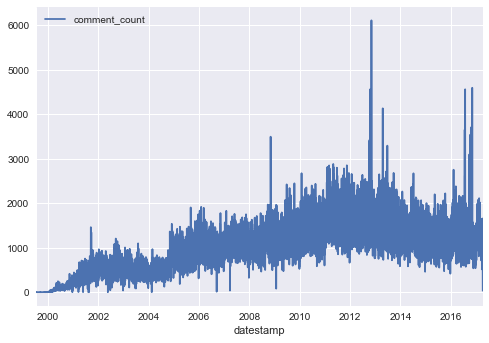

In [5]:
comments_per_day = df.loc[:, ['datestamp', 'commentid']].\
                      groupby(pd.Grouper(key='datestamp', freq='1D')).\
                      count().\
                      rename(columns={'commentid': 'comment_count'}).\
                      fillna(0).reset_index()
comments_per_day.plot(x='datestamp', y='comment_count')

### Rolling Averages
We want to look a bit at trends over time, so calculate rolling averages over four week periods and plot 

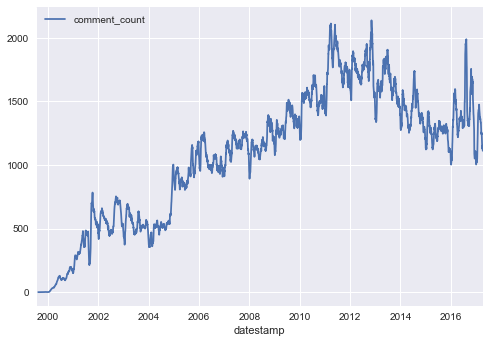

In [6]:
avg_comments_per_four_weeks = comments_per_day.set_index('datestamp').\
                                               rolling(28).\
                                               mean().\
                                               reset_index()

avg_comments_per_four_weeks.plot(x='datestamp', y='comment_count')

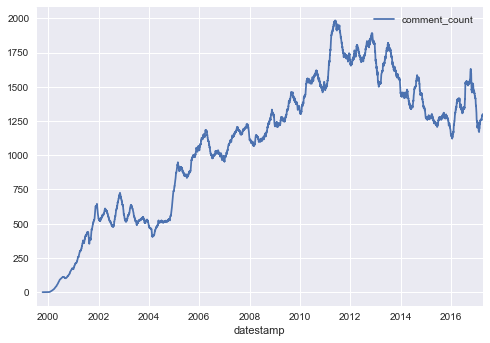

In [7]:
avg_comments_per_ninety = comments_per_day.set_index('datestamp').\
                                           rolling(90).\
                                           mean().\
                                           reset_index()

avg_comments_per_ninety.plot(x='datestamp', y='comment_count')

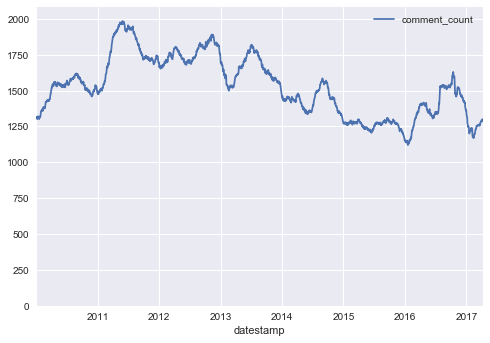

In [8]:
since_2010 = avg_comments_per_ninety.loc[avg_comments_per_ninety.datestamp > dt.datetime(2010, 1, 1), :]
since_2010.plot(x='datestamp', y='comment_count',ylim=(0, since_2010.comment_count.max() + 100))

## Political thread comments relative to all comments
The site's been a lot more political lately. How many of the comments have gone into political threads?

### Standard Threads
#### Overall

In [9]:
comments_per_post['is_political'] = comments_per_post.postid.apply(lambda x: x in politics_threads)
comments_per_post.groupby('is_political')['comment_count'].sum()

is_political
False    6464008
True      463057
Name: comment_count, dtype: int64

#### Per Year

(Bear in mind that many of the indicators we're using for political threads didn't exist before the Obama years. *That said,* American politics, Hillary Clinton, Bernie Sanders, Donald Trump, and Barrack Obama were all discussed before their presidential campaigns.) 

In [10]:
df_2 = store['/mefi/postdata'].loc[:, ['postid', 'datestamp']]
df_2['year'] = df_2.datestamp.apply(lambda x: x.year)
df_2 = df_2.loc[:, ['postid', 'year']]

political_comments_per_year_df = comments_per_post.merge(df_2).\
                                                   loc[:, ['is_political', 'year', 'comment_count']].\
                                                   pivot_table(columns=['is_political'],
                                                               index=['year'],
                                                               aggfunc=np.sum)

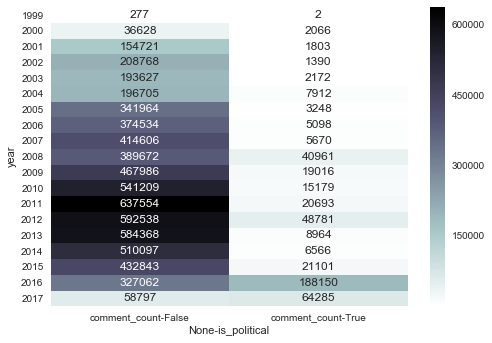

In [11]:
sns.heatmap(political_comments_per_year_df, annot=True, cmap='bone_r', fmt='d')

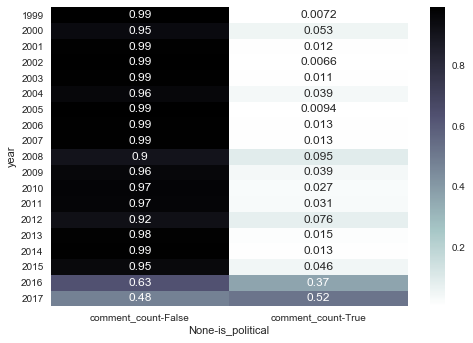

In [12]:
sns.heatmap(political_comments_per_year_df.div(political_comments_per_year_df.sum(axis=1),
                                               axis=0),
            annot=True,
            cmap='bone_r')

### Mega-Threads

What about *mega-threads*, which we'll say are threads with at least 500 comments in them? There are relatively fewer mega-threads than others, but they can perhaps give a sense of the truly hot button topics in the community at the moment.

In [13]:
comments_per_megathread = comments_per_post.loc[comments_per_post.comment_count > 499]

#### Overall

In [14]:
comments_per_megathread.groupby('is_political')['comment_count'].sum()

is_political
False    297956
True     314481
Name: comment_count, dtype: int64

#### Per Year

In [15]:
megathread_policomments_per_year_df = comments_per_megathread.merge(df_2).\
                                                              loc[:, ['is_political', 'year', 'comment_count']].\
                                                              pivot_table(columns=['is_political'],
                                                                          index=['year'],
                                                                          aggfunc=np.sum).\
                                                              fillna(0)

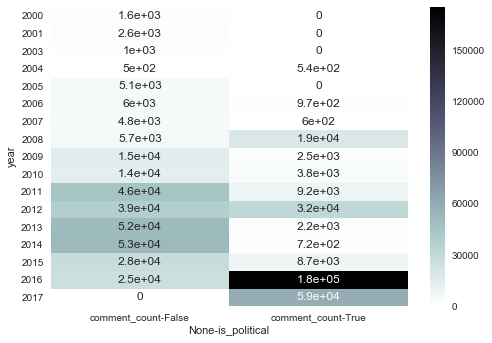

In [16]:
sns.heatmap(megathread_policomments_per_year_df, annot=True, cmap='bone_r')

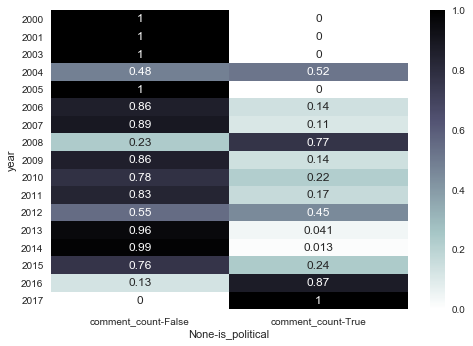

In [17]:
sns.heatmap(megathread_policomments_per_year_df.div(megathread_policomments_per_year_df.sum(axis=1),
                                                    axis=0),
            annot=True,
            cmap='bone_r')

## Political Megathreads relative to all threads
Same question, but just for the threads themselves - how many politics threads have their been relative to other threads? Frankly, we'd expect that level to be dropping down.

#### Overall

In [18]:
comments_per_megathread.groupby('is_political')['postid'].count()

is_political
False    299
True     136
Name: postid, dtype: int64

#### Per Year

In [69]:
megathreads_per_year_df = comments_per_megathread.merge(df_2).loc[:, ['is_political', 'year']].\
                                                             assign(dummy=1).\
                                                             pivot_table(columns=['is_political'],
                                                                         index=['year'],
                                                                         aggfunc=np.sum).\
                                                             fillna(0).astype(int)

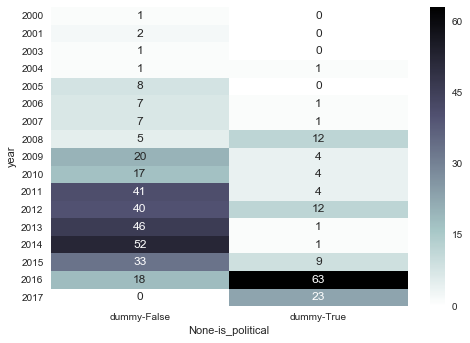

In [70]:
sns.heatmap(megathreads_per_year_df, annot=True, cmap='bone_r', fmt='d')

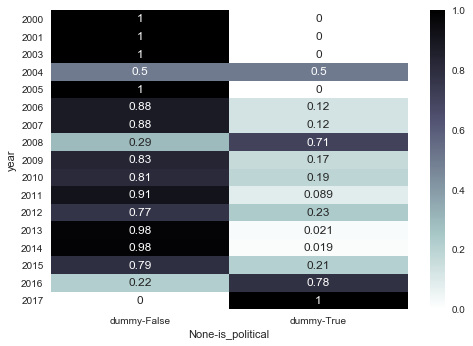

In [71]:
sns.heatmap(megathreads_per_year_df.div(megathreads_per_year_df.sum(axis=1),
                                        axis=0),
            annot=True,
            cmap='bone_r')

## User contribution - political threads relative to elsewhere
We don't have any statistics about where users lurk, but we do know where they comment and what they mark as a "favorite" - two limited measures of assessing interaction. How much "interaction" have we seen the users do within these different threads?